## A wrong view of TD equation
As from the TD equation $V(s_t) = V(s_t) +\alpha (R_t - V(s_t))$, intuitively we see the term $R_t - V(s_t)$ as somewhat of supervised learning fashion, as we treat V(s_t) as the expectation of the reward given the current state is $s_t$ and we try to minimize the difference between estimated reward and the true reward collected at time t. This view along with the form of the equation remind us of the gradient based method, seeing $(R_t - V(s_t))$ as the gradient of some function E, and we are trying to optimize this funciton. However, later on we will prove that this gradient based view is wrong, and a more plausible way of viewing TD is through Markov process.

## Markov process view of TD equation
Now consider that we are in the setting of Markov process. Let us define $w_s$ as the probability of state s giving rise to the terminal state z, and then $w_s$ can be estimated through emperical frequency, i.e.: $w_s = n_zs/n_s$, where n_zs is the frequency of seeing z after s, and n_s is just the frequency seeing s. Then we can derive an iterative update for $w_s$. After we encounter the state s, two things could happen, either we go directly into the terminal state z or we go to some other state r. Denote the transition probability from state s to state r as $P_sr$, and the probability of encountering terminal state after seeing s as $h_s$, we will have $w_s = h_s + \sum_r P_sr w_r$ as our interative update rule. All these probability can be estimated from sample, i.e. $P_sr = m_sr/n_s$, $h_s = m_sz/n_s$ where $m_sr$ is the frequency of seeing r after seeing s. So now, plug these estimate back to the update euqation, we will have: $\sum_r{m_sr w_s} - n_s w_s + m_sz = 0$, and then we can write it in matrix form, $(M - N)w + m = 0$. This is our familiar linear system again, denote M - N as A while m as b, and the iterative solution to this system should be $w = w + \alpha (Aw +n)$. However if we view this form as a gradient update, then the function we try to optimize would be $(Aw + b - 0)^2$ and the true gradient update would be $w = w + \alpha A^T(Aw +b)$ thus it's different from the iterative rule we had. 
<br />
<br />
Another justification of this would be looking into the second order of the derivative. Now let us define $x_t$ as a vector of all zeros with the only one appearing on the corresponding state that it is current in. For example, suppose we have 2 state, {0, 1}, in total and at time 1, the process enter state 0, then $x_1 = [1, 0]$. Also, define $\sigma_{s_t, z}$ being one only if $s_t$ is actually $z$. Then our updating rule can be rewritten as $w = w + \alpha ((x_t \otimes x_{t+1} - x_t \otimes x_{t})w + x_t \sigma_{s_{t+1}, z})$. Now for this update to be a gradient based method, the gradient of the corresponding function E has to be $(x_t \otimes x_{t+1} - x_t \otimes x_{t})w + x_t \sigma_{s_{t+1}, z}$. If we take the second order of derivative w.r.t $w_j$ and $w_i$, the result will be $\frac{\partial^2 E}{\partial w_i \partial w_j} = x_{ti}(x_{(t+1)j} - x_{tj})$ and  $\frac{\partial^2 E}{\partial w_j \partial w_i} = x_{tj}(x_{(t+1)i} - x_{ti})$. However, these two values in general will not equal to each other as  $x_{ti}x_{(t+1)j}$ will generally not equal to $x_{tj}x_{(t+1)i}$. 

## Experiment for the first order Markov Model

Here we want to conduct experiment to see if this TD like update equation will actually recover the probability of termination given different states. The Markov model that we use is as shown in the following graph. 
<img src="files/Markov_model.png">

Here we have in total seven states, let us denote them as 0 to 6, from left side to right. State 0 and 6 arethe termination state, and the process always start with state 3 and each transfer probability is 1/3. We generate different number of samples ranging from 5 to 1000 and we evaluate the performance based on the mean squared error between the predicted probability of termination given each state, which is $w_s$ and the true probability calculated through math. From the result we can observe that the error shrinks as we increase the sample size, also it reaches to a relatively small value, indicating this interative method works for the first order Markov Model. However, the result I got is not the same as in the paper, perhaps he used a differnent normalization method?

In [1]:
import numpy as np
def gen_first_order_samples(num_samples):
    A = np.asarray([[0.,0.,0.,0.,0.,0.,0.],
         [1/3,1/3,1/3,0.,0.,0.,0.],
         [0.,1/3,1/3,1/3,0.,0.,0.],
         [0.,0.,1/3,1/3,1/3,0.,0.],
         [0.,0.,0.,1/3,1/3,1/3,0.],
         [0.,0.,0.,0.,1/3,1/3,1/3],
         [0.,0.,0.,0.,0.,0.,0.]
        ])
    seq_samples = []
    for j in range(0, num_samples):
        obs = [3]
        while True:
            thr = np.random.randn(1)
            if thr <= 1/3:
                obs.append(obs[-1] - 1)
            elif thr <= 2/3:
                obs.append(obs[-1])
            else:
                obs.append(obs[-1] + 1)
            if obs[-1] == 0 or obs[-1] == 6:
                break
        seq_samples.append(np.asarray(obs))
    seq_samples = np.asarray(seq_samples)
    return seq_samples

In [38]:
def sum_to_one(x):
    return x/np.sum(x)
def cal_first_order_term_prob(index):
    temp = (1./3)**index
    temp2 = (1./3)**(6-index)
    return temp/(1.-temp) + temp2/(1.-temp2)

In [35]:
def gen_vecsamples_from_seqsamples(seq_samples):
    vec_samples = []
    for i in range(0, len(seq_samples)):
        vec = []
        for j in range(0, len(seq_samples[i])):
            temp = np.zeros(7)
            if seq_samples[i][j] != 0 and seq_samples[i][j] != 6:
                temp[seq_samples[i][j]] = 1.
            
            vec.append(temp)
        vec_samples.append(np.asarray(vec))
    return np.asarray(vec_samples)

In [58]:
def cal_prob_each_state(index):
    diff = abs(index - 3)
    if diff == 0:
        temp = (1./3)**1
        temp2 = (1./3)**2
        temp3 = (1./3)**4
        return temp/(1.-temp) + temp2/(1.-temp2) + temp3/(1.-temp3)
    if diff == 1:
        temp = (1./3)**1
        temp2 = (1./3)**3
        temp3 = (1./3)**5
        return temp/(1.-temp) + temp2/(1.-temp2) + temp3/(1.-temp3)
    if diff == 2:
        temp = (1./3)**2
        temp2 = (1./3)**4
        temp3 = (1./3)**6
        return temp/(1.-temp) + temp2/(1.-temp2) + temp3/(1.-temp3)
    

[0.07001067114703478, 0.07460664335664335, 0.04903846153846152, 0.07460664335664335, 0.07001067114703478]


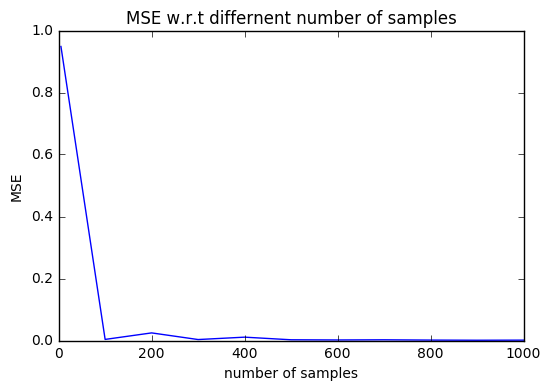

In [80]:
def sum_to_one(x):
    #x = x-min(x)
    #x = abs(x)
    return x/np.sum(x)
sample_size = [5, 100, 200, 300, 400, 500, 600,700,800,900,1000]
true = []

for i in range(1, 6):
    temp = cal_first_order_term_prob(i)
    #print temp
    true.append(temp* cal_prob_each_state(i))
#true = cal_first_order_term_prob()
print true
total_err = []
for t in range(0, 10000):
    error = []
    for i in range(0, len(sample_size)):
        seq_samples = gen_first_order_samples(sample_size[i])
        vec_samples = gen_vecsamples_from_seqsamples(seq_samples)
        sigma = [1, 0, 0, 0, 0, 0, 1]
        w = np.random.randn(7)
        for j in range(0, len(seq_samples)):
            for k in range(0, len(seq_samples[j])-1):
                temp1 = np.outer(vec_samples[j][k], vec_samples[j][k+1])
                temp2 = np.outer(vec_samples[j][k], vec_samples[j][k])
                if seq_samples[j][k+1] == 0 or seq_samples[j][k+1] == 6:
                    temp3 = vec_samples[j][k]
                else: temp3 = 0.
                w = w+0.01*(np.dot((temp1 - temp2), w)+temp3)
        w = sum_to_one(w)
        #print w
        error.append(np.mean((true - w[1:6])**2))
    #print '******'
    total_err.append(np.asarray(error))
total =  sum_to_one(np.mean(total_err, axis = 0))
from matplotlib import pyplot as plt
plt.title('MSE w.r.t differnent number of samples')
plt.xlabel('number of samples')
plt.ylabel('MSE')
#plt.axis([1, 1000, 0, 1])
plt.plot(sample_size, total)
plt.show()

### Reference
[1] Barnard E. Temporal-difference methods and Markov models[J]. IEEE Transactions on Systems, Man, and Cybernetics, 1993, 23(2): 357-365.